# CV - MNIST classificaiton using CNN 

By [Akshaj Verma](https://akshajverma.com)

This notebook takes you through the implementation of image classification MNIST dataset using CNNs in PyTorch.

In [1]:
import numpy as np
from time import time
import matplotlib.pyplot as plt


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets 


from sklearn.metrics import classification_report, confusion_matrix

In [2]:
%matplotlib inline
torch.manual_seed(1)

## Load MNIST Dataset

In [3]:
data_transform = transforms.Compose([
    transforms.ToTensor()
#     transforms.Normalize((0.1307,), (0.3081,))
])

train = datasets.MNIST('../../../data/computer_vision/mnist', train=True, download=True, transform=data_transform)

test = datasets.MNIST('../../../data/computer_vision/mnist', train=False, download=True, transform=data_transform)

## Data Loader

In [4]:
BATCH_SIZE = 64

In [5]:
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)

## EDA

### Input-output size

In [6]:
data_iter = iter(train_loader)
images, labels = data_iter.next()

print("Input images (batch, channels, height, width): ", images.size())
print("Output labels: ", labels.size())

Input images (batch, channels, height, width):  torch.Size([64, 1, 28, 28])
Output labels:  torch.Size([64])


### Example image from training data

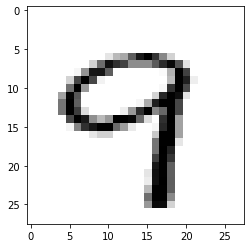

In [7]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

## Train a CNN for classification

In [72]:
class MnistClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(MnistClassifier, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc = nn.Linear(9*64, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [73]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [74]:
EPOCHS = 7
LEARNING_RATE = 0.001

model = MnistClassifier()
model.to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

MnistClassifier(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout2d(p=0.1, inplace=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout2d(p=0.2, inplace=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout2d(p=0.2, inplace=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_m

In [75]:
model.train()
for e in range(EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred_probs = model(X_batch)
        loss = criterion(y_pred_probs, y_batch)
        
        loss.backward()
        optimizer.step()
        
        _, y_pred = torch.max(y_pred_probs, dim = 1)
        batch_acc = (y_pred == y_batch).sum().item()/BATCH_SIZE
        
        epoch_loss += loss.item()
        epoch_acc += batch_acc
    
    print(f'Epoch {e+0:02}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.5f}')    

Epoch 00: | Loss: 0.94244 | Acc: 0.74439
Epoch 01: | Loss: 0.40810 | Acc: 0.88531
Epoch 02: | Loss: 0.36491 | Acc: 0.89919
Epoch 03: | Loss: 0.44363 | Acc: 0.88828
Epoch 04: | Loss: 0.48069 | Acc: 0.87755
Epoch 05: | Loss: 0.50695 | Acc: 0.87400
Epoch 06: | Loss: 0.54101 | Acc: 0.86486


## Save the model

In [76]:
torch.save(model.state_dict(), "mnist")

In [77]:
device = torch.device('cpu')
model = MnistClassifier()
model.load_state_dict(torch.load("mnist", map_location=device))

<All keys matched successfully>

In [78]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred_probs = model(X_batch)
        _, y_pred = torch.max(y_pred_probs, dim = 1)
        
        y_pred_list.append(y_pred.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

In [79]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90       980
           1       0.90      0.61      0.72      1135
           2       0.87      0.87      0.87      1032
           3       0.83      0.87      0.85      1010
           4       0.85      0.90      0.88       982
           5       0.85      0.88      0.86       892
           6       0.96      0.82      0.89       958
           7       0.93      0.87      0.90      1028
           8       0.58      0.88      0.70       974
           9       0.86      0.84      0.85      1009

    accuracy                           0.84     10000
   macro avg       0.86      0.84      0.84     10000
weighted avg       0.86      0.84      0.84     10000

